## **Install and Import Dependencies**

In [1]:
import mediapipe as mp
import cv2
import numpy
from matplotlib import pyplot as plt 

2023-09-01 16:33:05.725034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

## **Make Some Detections**

In [11]:

webcam = 0

cap = cv2.VideoCapture(webcam)
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.15, min_tracking_confidence=0.15) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
            #@ MediaPipe’s detection models require the input image to be non-writable for optimal performance.
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            #print(landmarks)
        except:
            pass
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=6, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=6, circle_radius=2) 
                                 )               
            #@ results.pose_landmarks: are all the landmarks the model predicts 
            #@ mp_pose.POSE_CONNECTIONS: we will see which landmarks are connecte with which landmarks 
        
        if webcam == 1:
            cv2.imshow('Mediapipe Feed', cv2.flip(image, 1))
        else:
            cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

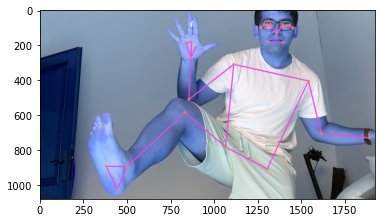

In [13]:
plt.imshow(image)


## **Save Video**

In [ ]:
cap = cv2.VideoCapture(0)

height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
fps = cap.get(cv2.CAP_PROP_FPS)
videoWriter = cv2.VideoWriter('press.avi', cv2.VideoWriter_fourcc('P', 'I', 'M', '1'), fps, (int(width), int(height)))

while cap.isOpened():
    ret, frame = cap.read()

    try:
        cv2.imshow('Press', frame)
        videoWriter.write(frame)
    except Exception as e:
        break

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
videoWriter.release()
cv2.destroyAllWindows()

## **Capture Landmarks & Export to CSV**

In [ ]:
import csv
import os
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
landmarks = ['class']
for val in range(1, 33+1): # 33 landmarks in total
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [ ]:
with open('coors.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [ ]:
def export_landmark(results, action):
    try:
        keypoints = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
        keypoints.insert(0,action)

        with open('coords.csv', mode='a', newline='') as f:
            csv_writer = csv.writer(f, delimeter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
    except Exception as e:
        pass

In [ ]:
cap = cv2.VideoCapture('press.avi')
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        # Recolor Feed
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        k = cv2.waitKey(1)
        if k == 117: # which letter does it correspond to??
            export_landmark(results, 'up')
        if k == 100:
            export_landmark(results, 'down')

        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


In [ ]:
cap.release()
cv2.destroyAllWindows()

## **Train Custom Model Using Scikit Learn**

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

#### - Create our Dataset

In [9]:
df = pd.read_csv('data/coords.csv')

X = df.drop('class', axis=1) # features
y=df['class'] #target value

In [10]:
print(df.head())
print(df.tail())
print(df[df['class']=='up'])
print(y)

  class        x1        y1        z1        v1        x2        y2        z2  \
0    up  0.533330  0.094314 -0.174967  0.999927  0.537605  0.084877 -0.153137   
1    up  0.550560  0.100491 -0.109032  0.999960  0.555267  0.096739 -0.090325   
2    up  0.550915  0.100399 -0.108349  0.999963  0.555819  0.096569 -0.089893   
3    up  0.550810  0.101509 -0.104391  0.999966  0.555683  0.097582 -0.085852   
4    up  0.550644  0.102910 -0.100850  0.999969  0.555470  0.099327 -0.082255   

         v2        x3  ...       z31       v31       x32       y32       z32  \
0  0.999868  0.540934  ...  0.064577  0.852087  0.596517  0.808435  0.053000   
1  0.999924  0.558621  ...  0.070714  0.876502  0.592692  0.804021 -0.055974   
2  0.999929  0.559235  ...  0.066859  0.877488  0.592766  0.804058 -0.052773   
3  0.999935  0.559128  ...  0.067669  0.876398  0.592839  0.804243 -0.050072   
4  0.999940  0.558899  ...  0.068803  0.875159  0.592833  0.804442 -0.042597   

        v32       x33       y33 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## **Train Machine Learning Classification Model**

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [6]:
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression()),
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

In [12]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## **Evaluate and Serialize Model**

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle

now we can see which one performs better...

In [13]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test.values, yhat),
          precision_score(y_test.values, yhat, average='binary', pos_label='up'),
          recall_score(y_test.values, yhat, average='binary', pos_label='up'))

lr 1.0 1.0 1.0
rc 1.0 1.0 1.0
rf 1.0 1.0 1.0
gb 1.0 1.0 1.0


now we use (fit) the one that we chose (higher accuracy??)

In [14]:
yhat = fit_models['rf'].predict(X_test)


## **Save Model**

In [27]:
with open('deadliftt.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

## ** Make Detections with Model

In [ ]:
landmarks = ['class']
for val in range(1, 33+1): # 33 landmarks in total
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [36]:
with open('deadliftt.pkl', 'rb') as f:
    model = pickle. load(f)

In [27]:
import numpy as np
webcam = 1
cap = cv2.VideoCapture(webcam)
counter = 0
current_stage = ''
with mp_pose.Pose(min_detection_confidence=0.15, min_tracking_confidence=0.15) as pose:
    
    while cap.isOpened():
        ret, image = cap.read()

        # Recolor Feed
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        try:
            row = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
            X = pd.DataFrame([row], columns = landmarks[1:])
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            
            if body_language_class == 'down' and body_language_prob[body_language_prob.argmax()] >= 0.7:
                current_stage = 'down'
            elif current_stage == 'down' and body_language_class == 'up' and body_language_prob[body_language_prob.argmax()] >= 0.7: # NON RIESCO A LEGGERE
                current_stage = 'up'
                counter +=1

            
            # GET STATUT BOX
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)

            # DISPLAY CLASS
            cv2.putText(image, 'CLASS', (95, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class.split(' ')[0], (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # DISPLAY PROBABILITY
            cv2.putText(image, 'PROB', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)], 2)), (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # DISPLAY COUNT
            cv2.putText(image, 'COUNT', (180, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter), (175,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        except Exception as e:
            print('VAFFANCULOOOO')

        if webcam == 1:
            cv2.imshow('Mediapipe Feed', cv2.flip(image, 1))
        else:
            cv2.imshow('Mediapipe Feed', image)


        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFANCULOOOO
VAFFAN

## Compress CVS 

In [44]:
import mediapipe as mp
import cv2
import numpy

import csv
import os
import numpy as np
from matplotlib import pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# TO CREATE THE FIRST ROW OF THE CSV FILE
landmarks = ['class']
for val in range(1, 33+1): # 33 landmarks in total
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

with open('/Users/danielguarnizo/Desktop/Computer Vision /Notes/CSV_files/coords_DL_C.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting = csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

def export_landmark(results, action):
    try:
        keypoints = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
        print(keypoints)
        keypoints.insert(0,action)

        with open('/Users/danielguarnizo/Desktop/Computer Vision /Notes/CSV_files/coords_DL_C.csv', mode='a', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
    except Exception as e:
        pass


cap = cv2.VideoCapture('Videos/CorrectDeadlift_45f.mp4')
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        # Recolor Feed
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        

        k = cv2.waitKey(1)
        if k == 117: # which letter does it correspond to??
            export_landmark(results, 'up')
        #if k == ord('u'):
            #export_landmark(results, 'up')
        if k == 100:
            export_landmark(results, 'down')
        #if k == ord('d'):
            #export_landmark(results, 'down')

        cv2.imshow('Raw Webcam Feed', image)

        key = cv2.waitKey(1)
        if key == ord('q'):
            break

cap.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

1   HIToolbox                           0x00007ff821943726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff8219432b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff8218b2cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff821943173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff81ae06287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff81ac5b055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   CoreFoundation                      0x00007ff817a356c6 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 137
8   CoreFoundation                      0x00007ff817acecac ___CFXRegistrationPost_block_invoke + 86
9   CoreFoundation                      0x00007ff817acec03 _CFXR

[0.37746521830558777, 0.20835034549236298, -0.4060174822807312, 0.9998107552528381, 0.38138100504875183, 0.18714997172355652, -0.4602889120578766, 0.9996147751808167, 0.3897508382797241, 0.18378965556621552, -0.4603257477283478, 0.9997245073318481, 0.3976805806159973, 0.18029125034809113, -0.4604436159133911, 0.9997445940971375, 0.365119993686676, 0.1917773336172104, -0.38536036014556885, 0.9995126724243164, 0.3618416488170624, 0.19178315997123718, -0.3853692412376404, 0.9994539022445679, 0.35882478952407837, 0.19153030216693878, -0.38559743762016296, 0.999413251876831, 0.4390210509300232, 0.17015516757965088, -0.5416921377182007, 0.9997617602348328, 0.3902212083339691, 0.1835629940032959, -0.19094732403755188, 0.9989685416221619, 0.411304771900177, 0.21753154695034027, -0.41806235909461975, 0.9998819828033447, 0.3944624960422516, 0.22310850024223328, -0.3168056607246399, 0.999640703201294, 0.6044874787330627, 0.23934288322925568, -0.6401607990264893, 0.9999779462814331, 0.387112826108

-1